In [2]:
import sys
import keras
import tensorflow as tf

print('python version:', sys.version)
print('keras version:', keras.__version__)
print('tensorflow version:', tf.__version__)

python version: 3.6.10 |Anaconda, Inc.| (default, Mar 23 2020, 17:58:33) [MSC v.1916 64 bit (AMD64)]
keras version: 2.3.1
tensorflow version: 2.1.0


# 6.3 Advanced use of recurrent neural networks
---
## A temperature-forecasting problem

### Inspecting the data of the Jena weather dataset

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

data_dir = 'jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


### Parsing the data

In [20]:
float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### Plotting the temperature timeseries

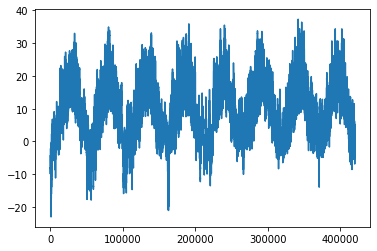

In [21]:
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

### Plotting the first 10 days of the temperature timeseries

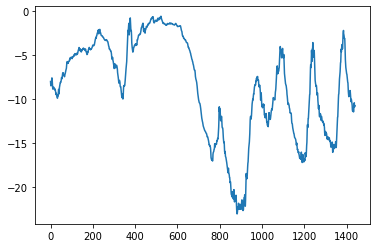

In [22]:
plt.plot(range(1440), temp[:1440])
plt.show()

### Normalizing the data

In [23]:
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

### Generator yielding timeseries samples and their targets

In [35]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle = False, batch_size = 128, step = 6, revert = False):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        if revert:
            yield samples[:, ::-1, :], targets
        else:
            yield samples, targets

### Preparing the training, validation and test generators

In [36]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

val_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 200001,
                      max_index = 300000,
                      step = step,
                      batch_size = batch_size)

test_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 300001,
                      max_index = None,
                      step = step,
                      batch_size = batch_size)

train_gen_r = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size,
                      revert = True)

val_gen_r = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 200001,
                      max_index = 300000,
                      step = step,
                      batch_size = batch_size,
                      revert = True)

test_gen_r = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 300001,
                      max_index = None,
                      step = step,
                      batch_size = batch_size,
                      revert = True)

# How many steps to draw from val_gen in order to see the entire validation set
val_steps = (300000 - 200001 - lookback) // batch_size

# How many steps to draw from test_gen in order to see the entire test set
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### Computing the common-sense baseline MAE

In [26]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


### Training and evaluating a densely connected model

In [27]:
from keras import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen,
                    steps_per_epoch = 500,
                    epochs = 20,
                    validation_data = val_gen,
                    validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 10s 19ms/step - loss: 1.8202 - val_loss: 0.8446
Epoch 2/20
500/500 [==============================] - 10s 21ms/step - loss: 0.6791 - val_loss: 0.2265
Epoch 3/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3430 - val_loss: 0.2910
Epoch 4/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2781 - val_loss: 0.2924
Epoch 5/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2604 - val_loss: 0.3348
Epoch 6/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2486 - val_loss: 0.3146
Epoch 7/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2408 - val_loss: 0.4443
Epoch 8/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2346 - val_loss: 0.3411
Epoch 9/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2283 - val_loss: 0.2246
Epoch 10/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2238 -

### Plotting results

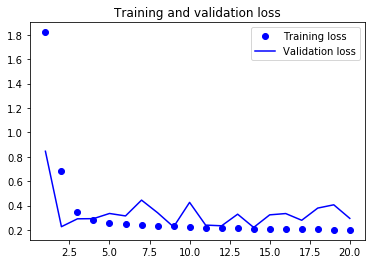

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Training and evaluating a GRU-based model

In [29]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     implementation = 1,
                     input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 115s 229ms/step - loss: 0.3059 - val_loss: 0.3201
Epoch 2/20
500/500 [==============================] - 112s 225ms/step - loss: 0.2843 - val_loss: 0.3513
Epoch 3/20
500/500 [==============================] - 112s 225ms/step - loss: 0.2773 - val_loss: 0.3569
Epoch 4/20
500/500 [==============================] - 112s 225ms/step - loss: 0.2717 - val_loss: 0.3344
Epoch 5/20
500/500 [==============================] - 112s 224ms/step - loss: 0.2698 - val_loss: 0.3761
Epoch 6/20
500/500 [==============================] - 113s 226ms/step - loss: 0.2637 - val_loss: 0.3804
Epoch 7/20
500/500 [==============================] - 112s 225ms/step - loss: 0.2613 - val_loss: 0.3553
Epoch 8/20
500/500 [==============================] - 113s 225ms/step - loss: 0.2556 - val_loss: 0.3289
Epoch 9/20
500/500 [==============================] - 113s 226ms/step - loss: 0.2519 - val_loss: 0.3276
Epoch 10/20
500/500 [==============================] - 112s 224m

### Plotting results

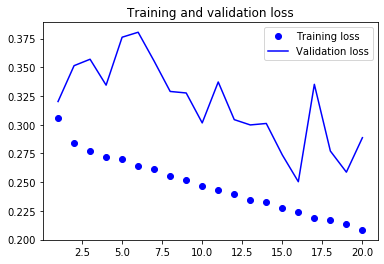

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Training and evaluating a dropout-regularized GRU-based model

In [31]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    implementation = 1,
                    dropout = 0.2,
                    recurrent_dropout = 0.2,
                    input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

history = model.fit_generator(train_gen,
                             steps_per_epoch = 500,
                             epochs = 40,
                             validation_data = val_gen,
                             validation_steps = val_steps)

Epoch 1/40
500/500 [==============================] - 136s 271ms/step - loss: 0.3316 - val_loss: 0.1537
Epoch 2/40
500/500 [==============================] - 136s 271ms/step - loss: 0.3135 - val_loss: 0.1398
Epoch 3/40
500/500 [==============================] - 132s 265ms/step - loss: 0.3090 - val_loss: 0.1072
Epoch 4/40
500/500 [==============================] - 132s 264ms/step - loss: 0.3028 - val_loss: 0.1021
Epoch 5/40
500/500 [==============================] - 133s 266ms/step - loss: 0.3001 - val_loss: 0.1034
Epoch 6/40
500/500 [==============================] - 132s 264ms/step - loss: 0.2977 - val_loss: 0.1081
Epoch 7/40
500/500 [==============================] - 132s 264ms/step - loss: 0.2952 - val_loss: 0.1078
Epoch 8/40
500/500 [==============================] - 132s 264ms/step - loss: 0.2935 - val_loss: 0.1141
Epoch 9/40
500/500 [==============================] - 132s 264ms/step - loss: 0.2922 - val_loss: 0.1095
Epoch 10/40
500/500 [==============================] - 132s 264m

### Plotting results

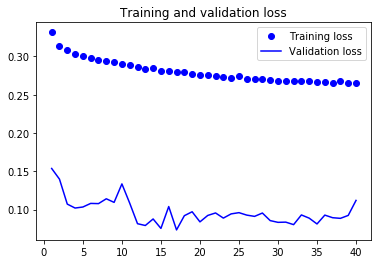

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Training and evaluating a dropout-regularized, stacked GRU model

In [33]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    implementation = 1,
                    dropout = 0.1,
                    recurrent_dropout = 0.5,
                    return_sequences = True,
                    input_shape = (None, float_data.shape[-1])))
model.add(layers.GRU(64,
                    implementation = 1,
                    activation = 'relu',
                    dropout = 0.1,
                    recurrent_dropout = 0.5))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

history = model.fit_generator(train_gen,
                             steps_per_epoch = 500,
                             epochs = 40,
                             validation_data = val_gen,
                             validation_steps = val_steps)

Epoch 1/40
500/500 [==============================] - 280s 560ms/step - loss: 0.3343 - val_loss: 0.3421
Epoch 2/40
500/500 [==============================] - 272s 544ms/step - loss: 0.3126 - val_loss: 0.2918
Epoch 3/40
500/500 [==============================] - 273s 546ms/step - loss: 0.3060 - val_loss: 0.2584
Epoch 4/40
500/500 [==============================] - 272s 543ms/step - loss: 0.3019 - val_loss: 0.2521
Epoch 5/40
500/500 [==============================] - 274s 547ms/step - loss: 0.3008 - val_loss: 0.2029
Epoch 6/40
500/500 [==============================] - 279s 557ms/step - loss: 0.2954 - val_loss: 0.1935
Epoch 7/40
500/500 [==============================] - 298s 596ms/step - loss: 0.2939 - val_loss: 0.1715
Epoch 8/40
500/500 [==============================] - 296s 592ms/step - loss: 0.2910 - val_loss: 0.1625
Epoch 9/40
500/500 [==============================] - 289s 578ms/step - loss: 0.2872 - val_loss: 0.1704
Epoch 10/40
500/500 [==============================] - 289s 578m

### Plotting results

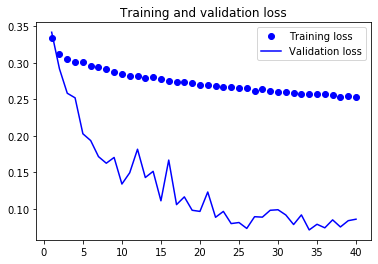

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Training and evaluating an GRU-based model using reversed sequences

In [37]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     implementation = 1,
                     input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

history = model.fit_generator(train_gen_r,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen_r,
                              validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 115s 230ms/step - loss: 0.4834 - val_loss: 0.1465
Epoch 2/20
500/500 [==============================] - 113s 227ms/step - loss: 0.4385 - val_loss: 0.2160
Epoch 3/20
500/500 [==============================] - 113s 227ms/step - loss: 0.3901 - val_loss: 0.2830
Epoch 4/20
500/500 [==============================] - 113s 226ms/step - loss: 0.3511 - val_loss: 0.1809
Epoch 5/20
500/500 [==============================] - 114s 227ms/step - loss: 0.3321 - val_loss: 0.2463
Epoch 6/20
500/500 [==============================] - 113s 227ms/step - loss: 0.3215 - val_loss: 0.2224
Epoch 7/20
500/500 [==============================] - 114s 228ms/step - loss: 0.3098 - val_loss: 0.2966
Epoch 8/20
500/500 [==============================] - 113s 227ms/step - loss: 0.2994 - val_loss: 0.2347
Epoch 9/20
500/500 [==============================] - 113s 226ms/step - loss: 0.2936 - val_loss: 0.3921
Epoch 10/20
500/500 [==============================] - 113s 227m

### Plotting results

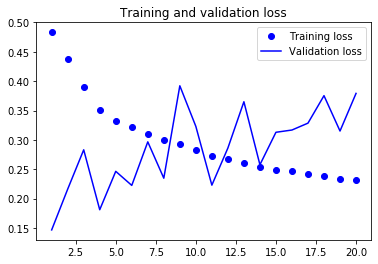

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Training and evaluating an LSTM using reversed sequences

In [40]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000 # Number of words to consider as features
maxlen = 500 # Cuts off texts after this number of words

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)

# Reverses sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pads sequences
x_train = sequence.pad_sequences(x_train, maxlen = maxlen)
x_test = sequence.pad_sequences(x_test, maxlen = maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['acc'])

history = model.fit(x_train, y_train,
                   epochs = 10,
                   batch_size = 128,
                   validation_split = 0.2)

C:\Users\alexa\anaconda3\envs\keras-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.5268 - acc: 0.7481 - val_loss: 0.4332 - val_acc: 0.8252
Epoch 2/10
20000/20000 [==============================] - 53s 3ms/step - loss: 0.3211 - acc: 0.8788 - val_loss: 0.3157 - val_acc: 0.8746
Epoch 3/10
20000/20000 [==============================] - 53s 3ms/step - loss: 0.2537 - acc: 0.9054 - val_loss: 0.3789 - val_acc: 0.8474
Epoch 4/10
20000/20000 [==============================] - 53s 3ms/step - loss: 0.2199 - acc: 0.9216 - val_loss: 0.3269 - val_acc: 0.8782
Epoch 5/10
20000/20000 [==============================] - 53s 3ms/step - loss: 0.1835 - acc: 0.9367 - val_loss: 0.3778 - val_acc: 0.8558
Epoch 6/10
20000/20000 [==============================] - 53s 3ms/step - loss: 0.1699 - acc: 0.9405 - val_loss: 0.4492 - val_acc: 0.8236
Epoch 7/10
20000/20000 [==============================] - 53s 3ms/step - loss: 0.1492 - acc: 0.9480 - val_loss: 0.3551 - val_acc:

### Training and evaluating a bidirectional LSTM

In [41]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['acc'])

history = model.fit(x_train, y_train,
                   epochs = 10,
                   batch_size = 128,
                   validation_split = 0.2)

C:\Users\alexa\anaconda3\envs\keras-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 104s 5ms/step - loss: 0.5797 - acc: 0.6987 - val_loss: 0.4622 - val_acc: 0.8088
Epoch 2/10
20000/20000 [==============================] - 103s 5ms/step - loss: 0.3475 - acc: 0.8630 - val_loss: 0.3299 - val_acc: 0.8832
Epoch 3/10
20000/20000 [==============================] - 103s 5ms/step - loss: 0.2720 - acc: 0.8989 - val_loss: 0.3867 - val_acc: 0.8600
Epoch 4/10
20000/20000 [==============================] - 102s 5ms/step - loss: 0.2321 - acc: 0.9169 - val_loss: 0.3415 - val_acc: 0.8772
Epoch 5/10
20000/20000 [==============================] - 102s 5ms/step - loss: 0.2131 - acc: 0.9244 - val_loss: 0.5082 - val_acc: 0.8020
Epoch 6/10
20000/20000 [==============================] - 103s 5ms/step - loss: 0.1898 - acc: 0.9340 - val_loss: 0.3849 - val_acc: 0.8384
Epoch 7/10
20000/20000 [==============================] - 104s 5ms/step - loss: 0.1714 - acc: 0.9408 - val_loss: 0.4671 - v

### Training a bidirectional GRU

In [42]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

history = model.fit_generator(train_gen,
                             steps_per_epoch = 500,
                             epochs = 40,
                             validation_data = val_gen,
                             validation_steps = val_steps)

Epoch 1/40
500/500 [==============================] - 212s 423ms/step - loss: 0.2905 - val_loss: 0.1895
Epoch 2/40
500/500 [==============================] - 211s 423ms/step - loss: 0.2767 - val_loss: 0.1619
Epoch 3/40
500/500 [==============================] - 211s 422ms/step - loss: 0.2714 - val_loss: 0.1248
Epoch 4/40
500/500 [==============================] - 211s 422ms/step - loss: 0.2648 - val_loss: 0.1712
Epoch 5/40
500/500 [==============================] - 211s 423ms/step - loss: 0.2581 - val_loss: 0.1517
Epoch 6/40
500/500 [==============================] - 211s 422ms/step - loss: 0.2538 - val_loss: 0.1478
Epoch 7/40
500/500 [==============================] - 211s 422ms/step - loss: 0.2483 - val_loss: 0.1221
Epoch 8/40
500/500 [==============================] - 211s 421ms/step - loss: 0.2426 - val_loss: 0.1392
Epoch 9/40
500/500 [==============================] - 211s 422ms/step - loss: 0.2379 - val_loss: 0.1258
Epoch 10/40
500/500 [==============================] - 213s 425m

KeyboardInterrupt: 

### Plotting results

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()